In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import chess

tablero = chess.Board()

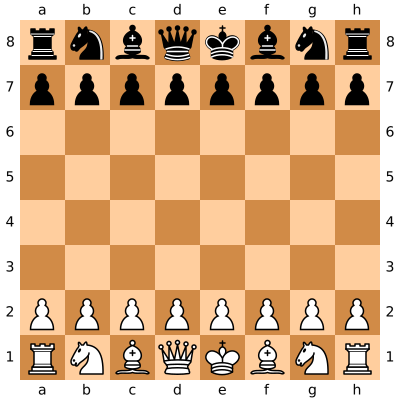

In [3]:
tablero

In [4]:
from keras.models import load_model

model1 = load_model('/content/drive/My Drive/Chess/model64_2ep64.h5')

model2 = load_model('/content/drive/My Drive/Chess/model64_0_1.h5')

In [5]:
import numpy as np

##Enlace con la database
def tablero_a_nums(fen_str):
    tablero_str, _, _, _, _, _ = fen_str.split(" ")
    for i in range(1, 9):
        tablero_str = tablero_str.replace(str(i), '.' * i).replace('/', '')
    piezas = ['.', 'P', 'N', 'B', 'R', 'Q', 'K', 'p', 'n', 'b', 'r', 'q', 'k']
    tablero_array = np.zeros(64)
    for i, elemento in enumerate(tablero_str):
        tablero_array[i] = piezas.index(elemento)
    return tablero_array

##Evaluador de nodos

def evaluate_position1(tablero):
    fen = tablero.fen()
    tablero_array = tablero_a_nums(fen)
    return model1.predict(np.asarray([tablero_array]))

def evaluate_position2(tablero):
    fen = tablero.fen()
    tablero_array = tablero_a_nums(fen)
    return model2.predict(np.asarray([tablero_array]))

In [6]:
class Node:
    
    def __init__(self, state, move=None, parent=None):
        self.move = move
        self.state = state
        self.parent = parent
        self.unexplored_moves = list(state.legal_moves)
        self.children = []
        self.visits = 0
        self.wins = 0
        
    def add_child(self, state, move):
        child_node = Node(state, move, self)
        self.children.append(child_node)
        self.unexplored_moves.remove(move)
        return child_node
        
    def UCT_select_child(self):
        s = sorted(self.children, key = lambda c: c.wins/c.visits + sqrt(2*log(self.visits)/c.visits) )[-1]
        return s
    
    def Update(self, result):
        self.visits += 1
        self.wins += result ###valor de victoria obtenida de la inteligencia artificial

In [7]:
import random
from math import sqrt, log
def UCT1(rootstate, itermax, depthmax):
    rootnode = Node(state = rootstate)
    for i in range(itermax):
        node = rootnode
        depth = 0
        state = rootstate.copy()

        # Selección
        while node.unexplored_moves == [] and node.children != []: # El nodo se ha expandido completamente
            node = node.UCT_select_child()
            state.push(node.move)

        # Expansión
        if node.unexplored_moves != []: # Si podemos seguir expandiendo
            m = random.choice(node.unexplored_moves) 
            state.push(m)
            node = node.add_child(state,m) # Añadir un hijo y seguir con el árbol 
            depth += 1

        # Simulación
        while list(state.legal_moves) != [] and depth < depthmax: # Mientras el estado permita
            state.push(random.choice(list(state.legal_moves)))
            depth += 1

        # Actualización
        while node != None: # Actualización del nodo expandido y se realiza la propagación hasta el nodo raíz 
            result = evaluate_position1(state)
            #print(result)   para ver los valores de los nodos en tiempo real
            clear_output(wait=True) 
            node.Update(result) #se actualiza el estado del nodo
            node = node.parent

    return sorted(rootnode.children, key = lambda c: c.visits)[-1].move

In [8]:
import random
from math import sqrt, log
def UCT2(rootstate, itermax, depthmax):
    rootnode = Node(state = rootstate)
    for i in range(itermax):
        node = rootnode
        depth = 0
        state = rootstate.copy()

        # Selección
        while node.unexplored_moves == [] and node.children != []: # El nodo se ha expandido completamente
            node = node.UCT_select_child()
            state.push(node.move)

        # Expansión
        if node.unexplored_moves != []: # Si podemos seguir expandiendo
            m = random.choice(node.unexplored_moves) 
            state.push(m)
            node = node.add_child(state,m) # Añadir un hijo y seguir con el árbol 
            depth += 1

        # Simulación
        while list(state.legal_moves) != [] and depth < depthmax: # Mientras el estado permita
            state.push(random.choice(list(state.legal_moves)))
            depth += 1

        # Actualización
        while node != None: # Actualización del nodo expandido y se realiza la propagación hasta el nodo raíz 
            result = evaluate_position2(state)
            node.Update(result)
            node = node.parent

    return sorted(rootnode.children, key = lambda c: c.visits)[-1].move

In [9]:
import time
from IPython.display import clear_output, display
import chess.pgn

tablero = chess.Board()

def play_game(player1, player2):
    while not tablero.is_game_over():
        if tablero.turn == chess.WHITE:
            player1(tablero)
        else:
            player2(tablero)
        clear_output(wait=True)
        display(tablero)
        time.sleep(0.01)
    game = chess.pgn.Game.from_board(tablero)
    print(game)

In [10]:
import random

def mcts_player1(tablero):
    move = None
    for move_choice in tablero.legal_moves:
        copy = tablero.copy()
        copy.push(move_choice)
        if copy.is_game_over():
            move = move_choice
            tablero.push(move)
            return
    if random.random() < 0.01:
        move = random.choice(list(tablero.legal_moves))
    else:
        move = UCT1(tablero, 64, 100)
    tablero.push(move)

def mcts_player2(tablero):
    move = None
    for move_choice in tablero.legal_moves:
        copy = tablero.copy()
        copy.push(move_choice)
        if copy.is_game_over():
            move = move_choice
            tablero.push(move)
            return
    move = UCT2(tablero, 64, 300)
    tablero.push(move)

def random_play(tablero):
  move = random.choice(list(tablero.legal_moves))
  tablero.push(move)

In [11]:
def human_player(tablero):
    while True:
        print(tablero.legal_moves )
        move = input("Cual es tu jugada: \n" )
        if move == "q":
            raise KeyboardInterrupt
        try:
            tablero.push_san(move)
            break 
        except Exception as e:
            print(e)

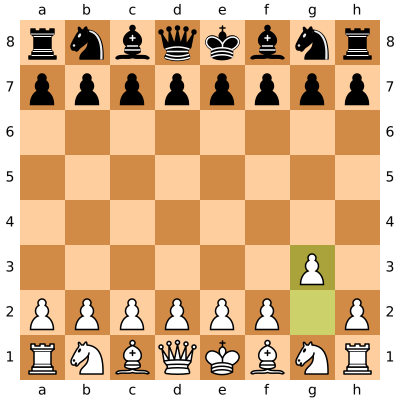

KeyboardInterrupt: ignored

In [12]:
tablero = chess.Board()

play_game(mcts_player1, mcts_player2)

In [ ]:
tablero = chess.Board()

play_game(human_player, mcts_player1)

<LegalMoveGenerator at 0x7f27cb250e50 (Nh3, Nf3, Nc3, Na3, h3, g3, f3, e3, d3, c3, b3, a3, h4, g4, f4, e4, d4, c4, b4, a4)>


In [ ]:
tablero = chess.Board()

play_game(random_play, mcts_player2)

In [ ]:
pip install PypeR

In [ ]:
import numpy

# {{{ Global constants

# No. of Simulations
TIMES = 100

# Lambda
LAMBDA = 2

# Stop-time
STOP_TIME = 100

# weather period
WEATHER_PERIOD = 3

# Good weather period
GOOD_WEATHER_PERIOD = 2

# infinity
INFINITY = 10000

# }}}

# First arrival of the message after time T0
def poisson_arrival(T0):
    random = numpy.random.uniform(0,1)
    return T0 - (1.0/LAMBDA)*numpy.log(random)

# Returns 1 for 'Good' weather or 0 for 'Rough' weather
def weather(time):
    if int(time)%WEATHER_PERIOD == GOOD_WEATHER_PERIOD:
        return 0
    return 1

# Simulates 'size' times
def simulation(size):
    results=[]
    for x in xrange(size):
        departureTime = [INFINITY, INFINITY, INFINITY]
        availability = [1,1,1]
        arrivalTime = poisson_arrival(0)
        time = arrivalTime
        lost = 0

        while time < STOP_TIME:
            # {{{ Simulate the arrival of the new message
            if arrivalTime < min(departureTime):
                time = arrivalTime
                if sum(availability) > 0:
                    currWeather = weather(time)
                    Y = numpy.random.uniform(0,1)
                    if currWeather is 0:
                        Y = Y**(0.33)
                    for y in xrange(len(availability)):
                        if availability[y] is 1:
                            departureTime[y] = time+Y
                            availability[y] = 0
                            break
                else:
                    lost += 1
                arrivalTime = poisson_arrival(time)
            # }}}
            # {{{ Simulate the departure of one of the pending messages
            else:
                time = min(departureTime)
                for var in xrange(len(availability)):
                    if departureTime[var] <= min(departureTime):
                        departureTime[var] = INFINITY
                        availability[var] = 1
                        break
            # }}}

        results.append(lost)
        print ("Sample" + +str(x+1),lost)
    print ("# Samples:" + str(len(results)) + ", Result:",sum(results)*1.0/len(results))

if __name__ == '__main__':
    simulation(TIMES)